In [2]:
import pandas as pd
import numpy as np
import joblib
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- CONFIGURATION ---
DATA_PATH = 'HCM.csv'       # Input data file
CITY_NAME = "Ho_Chi_Minh_City" # Name for saving model files

# Forecast Horizons (Hours)
HORIZONS = {'1h': 1, '24h': 24, '48h': 48}

# Target Variables
TARGETS = ['temp', 'precip', 'humidity']

# Input Features (Excluded 'feelslike', 'dew' to prevent data leakage)
FEATURE_COLS = [
    'humidity', 'precip', 'precipprob', 'windgust', 'windspeed', 'winddir',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'uvindex', 'severerisk', 'hour', 'month'
]

In [3]:
def load_and_process_data(filepath):
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    
    # Normalize column names (lowercase, strip spaces)
    df.columns = df.columns.str.strip().str.lower()
    
    # Process Datetime
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.sort_values('datetime').reset_index(drop=True)
        # Feature Engineering: Extract Hour and Month
        df['hour'] = df['datetime'].dt.hour
        df['month'] = df['datetime'].dt.month
        
    return df

def create_future_targets(df):
    df_processed = df.copy()
    future_cols = []
    
    print("Generating future targets (Time Lag Shifting)...")
    for h_name, h_step in HORIZONS.items():
        for t in TARGETS:
            new_col = f'{t}_future_{h_name}'
            # Shift data backwards: Row i contains target for time i + h_step
            df_processed[new_col] = df_processed[t].shift(-h_step)
            future_cols.append(new_col)
            
    # Drop last rows containing NaNs due to shifting
    df_processed = df_processed.dropna(subset=future_cols)
    return df_processed, future_cols

In [10]:
# 1. Load Data
df = load_and_process_data(DATA_PATH)
df_train, future_target_names = create_future_targets(df)

print(f"Data shape for training: {df_train.shape}")

# --- HANDLE MISSING VALUES (IMPORTANT) ---
# Ensure input features contain no NaNs (Linear Regression will crash otherwise)
available_features = [c for c in FEATURE_COLS if c in df_train.columns]
df_train[available_features] = df_train[available_features].fillna(0)

if df_train[available_features].isnull().values.any():
    print("Warning: Data still contains NaN values!")
else:
    print("✅ Data is clean (No NaN).")

# 2. Normalize Input Features
scaler = StandardScaler()
X_all = scaler.fit_transform(df_train[available_features])

# 3. Model Configurations
models_config = {
    'LinearReg': LinearRegression(),
    
    'RandomForest': RandomForestRegressor(
        n_estimators=50, 
        max_depth=10, 
        n_jobs=-1, 
        random_state=42
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=100, 
        learning_rate=0.05, 
        max_depth=5, 
        n_jobs=-1, 
        random_state=42
    )
}

# 4. Training Loop
results = []
trained_models = {}

print(f"\n--- STARTING TRAINING PIPELINE ---")
for target_col in future_target_names:
    y_all = df_train[target_col]
    
    # Split Data (Time-series split: No Shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)
    
    print(f"Training target: {target_col}...", end=" ")
    
    for name, model in models_config.items():
        # Clone model to ensure fresh training
        import copy
        clf = copy.deepcopy(model)
        
        start = time.time()
        clf.fit(X_train, y_train)
        end = time.time()
        
        # Evaluate
        preds = clf.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        # Log results
        parts = target_col.split('_future_') # Split: temp_future_24h -> temp, 24h
        results.append({
            'Target': parts[0],
            'Horizon': parts[1],
            'Model': name,
            'RMSE': rmse,
            'Time': end - start
        })
        
        # Save trained model to dict
        trained_models[f"{name}_{target_col}"] = clf
    
    print("Done.")

print("\n✅ Training pipeline completed!")

Loading data from HCM.csv...
Generating future targets (Time Lag Shifting)...
Data shape for training: (51816, 33)
✅ Data is clean (No NaN).

--- STARTING TRAINING PIPELINE ---
Training target: temp_future_1h... Done.
Training target: precip_future_1h... Done.
Training target: humidity_future_1h... Done.
Training target: temp_future_24h... Done.
Training target: precip_future_24h... Done.
Training target: humidity_future_24h... Done.
Training target: temp_future_48h... Done.
Training target: precip_future_48h... Done.
Training target: humidity_future_48h... Done.

✅ Training pipeline completed!


In [11]:
# --- SAVE METRICS ---
results_df = pd.DataFrame(results)

# Display Pivot Table
print("=== RMSE PERFORMANCE COMPARISON (Lower is Better) ===")
pivot_table = results_df.pivot_table(
    index=['Target', 'Horizon'], 
    columns='Model', 
    values='RMSE'
)
display(pivot_table)

# Save to CSV
os.makedirs('saved_models', exist_ok=True)
results_df.to_csv('saved_models/validation_metrics.csv', index=False)
print("Metrics saved to 'saved_models/validation_metrics.csv'")

# --- SAVE MODELS ---
bundle = {
    'models': trained_models,
    'scaler': scaler,
    'features': available_features, 
    'horizons': HORIZONS
}

filename = 'saved_models/xgb_weather_models.joblib'
joblib.dump(bundle, filename)
print(f"✅ Models saved to: {filename}")

=== RMSE PERFORMANCE COMPARISON (Lower is Better) ===


Model             LinearReg  RandomForest   XGBoost
Target   Horizon                                   
humidity 1h        5.011479      4.669705  4.584086
         24h       8.502125      8.049919  7.935288
         48h       9.488192      8.723253  8.606550
precip   1h        2.585371      2.674435  2.593011
         24h       2.536143      2.583378  2.515764
         48h       2.571615      2.766384  2.848725
temp     1h        1.632957      1.171945  1.173280
         24h       1.798163      1.555850  1.535459
         48h       1.868081      1.618756  1.604438

Metrics saved to 'saved_models/validation_metrics.csv'
✅ Models saved to: saved_models/xgb_weather_models.joblib


In [12]:
os.makedirs('saved_models', exist_ok=True)

bundle = {
    'models': trained_models,
    'scaler': scaler,
    'features': available_features, # Lưu lại danh sách cột đã dùng
    'horizons': HORIZONS
}

filename = f'saved_models/{CITY_NAME}_models.joblib'
joblib.dump(bundle, filename)
print(f"✅ Đã lưu model tại: {filename}")

✅ Đã lưu model tại: saved_models/Ho_Chi_Minh_City_models.joblib


✅ feature_importance.png saved successfully!


/var/folders/kh/9j76x6yd4q18d4m64gkf0mf80000gn/T/ipykernel_90194/4204370911.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


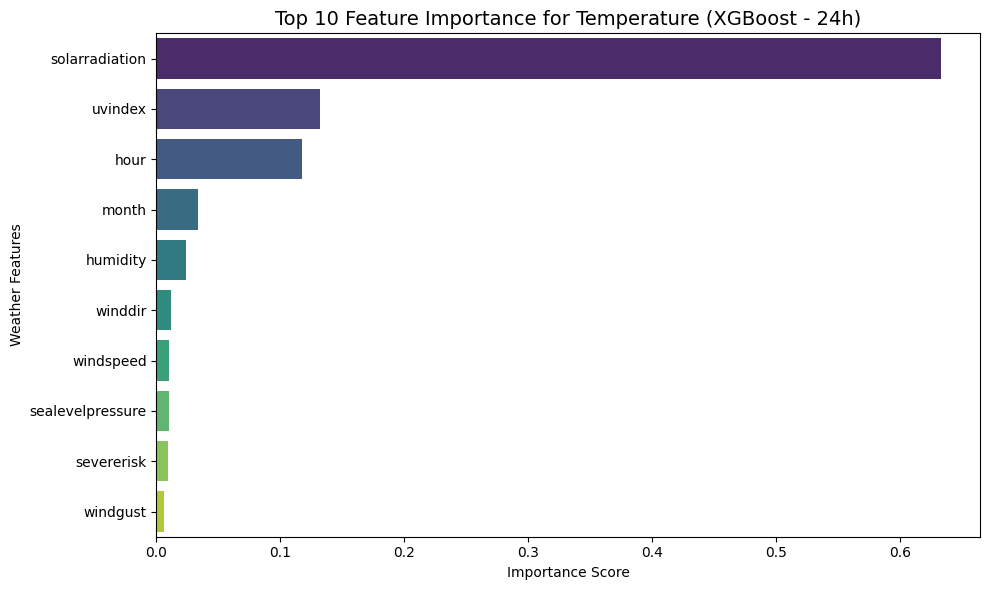

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have finished training the model and it is stored in 'trained_models'
# Extract the XGBoost model predicting temperature for the next 24h for analysis
# (This key must match the key used in your training code, e.g., 'XGBoost_temp_future_24h')
model_key = 'XGBoost_temp_future_24h' 

if model_key in trained_models:
    model = trained_models[model_key]
    
    # Get feature importance scores
    importance = model.feature_importances_
    # Get feature names from the FEATURE_COLS variable you defined earlier
    feature_names = FEATURE_COLS 
    
    # Create a DataFrame for plotting
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    # Sort and get the Top 10 most important features
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    
    # Set titles and labels in English
    plt.title('Top 10 Feature Importance for Temperature (XGBoost - 24h)', fontsize=14)
    plt.xlabel('Importance Score')
    plt.ylabel('Weather Features')
    plt.tight_layout()
    
    # SAVE IMAGE FILE
    plt.savefig('feature_importance.png', dpi=300) # <--- This is the file you need!
    print("✅ feature_importance.png saved successfully!")
    plt.show()
else:
    print(f"Error: Model '{model_key}' not found. Please check the key name in the 'trained_models' dictionary.")